In [108]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse
from tqdm import tqdm

In [457]:
def effective_prey(S, M, V):
    T = M + V # Total prey at each phenotype
    return T[None, None, :, :] * S # Prey x probability predator eats prey

def predation_matrix(S, effective_prey, R, a=1, h=0.5):
    D = a * effective_prey / (1 
                  + effective_prey.sum(axis = (0, 1))[None, None, :, :] 
                  + a*h*(R + effective_prey.sum(axis = (2, 3))[:, :, None, None]))
    return D

def update_predators(P, M, V, D, v, effective_prey, eta=0.85, d=0.2, mr=0.001, cutoff=1e-6, dt=0.01):

    prey_eaten = D.sum(axis=(2,3))
    assert prey_eaten.shape == P.shape
    T = M + V
    v_adj = V * v / T # adjusted venomosity at given phenotype
    v_adj = np.nan_to_num(v_adj)

    # contribution from M, V
    dP = prey_eaten * (eta * (1 - v_adj) - v_adj) - P * d

    # contribution from R
    Np = np.sum(P)
    dP += eta * P * a * R / (1 + Np + a*h*(R + effective_prey.sum(axis = (2, 3))))
    
    # assert np.all(~np.isnan(prey_eaten))
    # assert np.all(~np.isnan(v_adj))
    # assert np.all(~np.isnan(dP))

    P_new = P + dP * dt
    P_new[P_new < cutoff] = 0

    P_new = mutate_phenotype(P_new, mr)
    
    return P_new

def update_prey(V, M, D, r=1, K=1000, mr=0.01, cutoff=1e-6, dt=0.01):

    T = M + V
    pv = V / T
    pv = np.nan_to_num(pv)
    pm = M / T
    pm = np.nan_to_num(pm)
    
    predation = D.sum(axis=(0, 1))

    dV = V * r * (1 - np.sum(V) / K) - predation * pv
    dM = M * r * (1 - np.sum(M) / K) - predation * pm

    V = V + dV * dt
    V[V < cutoff] = 0
    V = mutate_phenotype(V, mr)

    M = M + dM * dt
    M[M < cutoff] = 0
    M = mutate_phenotype(M, mr)

    return V, M

def update_R(R, P, r, K, effective_prey, a, h, cutoff=1e-6, dt=0.01):
    Np = np.sum(P)
    dR_i = - P * a * R / (1 
                  + Np 
                  + a*h*(R + effective_prey.sum(axis = (2, 3))))
    dR = np.sum(dR_i)
    # assert not np.isnan(dR), dR_i
    dR += R * r * (1 - R / K)
    R_new = R + dR * dt
    if R_new < cutoff:
        return 0
    else:
        return R_new

def mutate_phenotype(A, mr):

    L = len(A)
    A_padded = np.zeros((L+2, L+2))
    A_padded[1:L+1, 1:L+1] = A
    A_padded[L+1, 1:L+1] = A[0]
    A_padded[0, 1:L+1] = A[L-1]
    A_padded[1:L+1, 0] = A[:,L-1]
    A_padded[1:L+1, L+1] = A[:,0]
    A_diff = 4 * A - A_padded[2:L+2, 1:L+1] - A_padded[0:L, 1:L+1] - A_padded[1:L+1, 2:L+2] - A_padded[1:L+1, 0:L]
    
    assert np.isclose(np.sum(A_diff),0), np.sum(A_diff)
    A -= mr * A_diff
    return A

def update(S, P, V, M, R, v, 
           a=1, h=0.5, eta=0.85, d=0.2, 
           r_prey=1, K_prey=1000, r_R=1, K_R = 1000,
          mr=0.01, mr_P=0.01, dt=0.1):

    ep = effective_prey(S, M, V)
    # assert np.all(~np.isnan(ep))
    D = predation_matrix(S, ep, R, a, h)
    D = P[:, :, None, None] * D
    # assert np.all(~np.isnan(D))
    P_new = update_predators(P, M, V, D, v, ep, eta, d, mr_P)
    # assert np.all(~np.isnan(P_new))
    V_new, M_new = update_prey(V, M, D, r_prey, K_prey, mr)
    # assert np.all(~np.isnan(V_new))
    # assert np.all(~np.isnan(M_new))
    R_new = update_R(R, P, r_R, K_R, ep, a, h)

    return P_new, V_new, M_new, R_new

# define a lattice representing phenotype space
def make_lattice(gridsize, length, ndims):
    axes = [np.arange(0, length, gridsize)+gridsize/2 for dim in range(ndims)]
    return np.meshgrid(*axes)

ncells = 20
length = 2
gridsize = length / ncells
xv, yv = make_lattice(gridsize, length, 2)
xv = np.round(xv, 8)
yv = np.round(yv, 8)

L = xv.shape[0]

xdists = abs(xv - xv[:, :, np.newaxis, np.newaxis])
xdists = np.minimum(xdists, length - xdists)
ydists = abs(yv - yv[:, :, np.newaxis, np.newaxis])
ydists = np.minimum(ydists, length - ydists)
dists = np.round(np.sqrt(xdists**2 + ydists**2), 8)
# So now dists[i,j,k,l] = ||x_{i,j} - x_{k,l}||

In [464]:
P0 = np.zeros(xv.shape)
M0 = np.zeros(xv.shape)
V0 = np.zeros(xv.shape)
# Distribute some random population
for _ in range(100):
    for target in (P0, M0, V0):
        target[*np.random.choice(L, 2)] += np.random.exponential(5)
R0 = 500
v = 0.3
a = 1
h = 0.25
r_R = 0.5
K_R = 500
dt = 1
mr = 0.005
mr_P = 0.005
d = 0.3
std = 0.1
K_prey=1000
r_prey=1.5

def preference(dist, std=0.1):
    return 1 - np.exp(-dist**2 / (2 * std**2))
    
S = preference(dists, std)

In [465]:
P_hist = [P0]
V_hist = [V0]
M_hist = [M0]
R_hist = [R0]
ngen = 10000
for gen in tqdm(range(1, ngen)):
    
    P, V, M, R = update(S, P_hist[gen-1], V_hist[gen-1], M_hist[gen-1], R_hist[gen-1], 
                        v, a, h, eta=0.85, d=d, r_prey=r_prey, K_prey=K_prey, r_R=r_R, K_R=K_R, mr=mr, mr_P=mr_P, dt=dt)
    P_hist.append(P)
    V_hist.append(V)
    M_hist.append(M)
    R_hist.append(R)

  0%|                                                  | 0/9999 [00:00<?, ?it/s]/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_26613/886676202.py:16: RuntimeWarning: invalid value encountered in divide
  v_adj = V * v / T # adjusted venomosity at given phenotype
/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_26613/886676202.py:40: RuntimeWarning: invalid value encountered in divide
  pv = V / T
/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_26613/886676202.py:42: RuntimeWarning: invalid value encountered in divide
  pm = M / T
100%|██████████████████████████████████████| 9999/9999 [00:26<00:00, 371.74it/s]


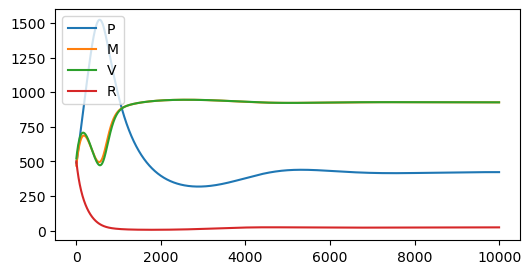

In [466]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot([np.sum(p) for p in P_hist], label = 'P')
ax.plot([np.sum(m) for m in M_hist], label = 'M')
ax.plot([np.sum(v) for v in V_hist], label = 'V')
ax.plot([r for r in R_hist], label='R')
ax.legend()

In [ ]:
from matplotlib import animation
steps_per_frame = 100
fig, axes = plt.subplots(1, 3, figsize=(13,4))
vmin=0
vmax=5
nframes = len(P_hist)
def animate(i):
    # Remove old points
    for ax in axes:
        for artist in ax.get_lines()+ax.collections:
            artist.remove()

    t = i * steps_per_frame
    P_t = P_hist[t]
    V_t = V_hist[t]
    M_t = M_hist[t]
    for ax, pop in zip(axes, [P_t, V_t, M_t]):
        pcmap = ax.pcolormesh(xv, yv, pop, 
                          antialiased=False, cmap='magma', vmin=0, vmax=vmax)
        ax.set_xticks(np.arange(0, length+gridsize, gridsize)[::5])
        ax.set_yticks(np.arange(0, length+gridsize, gridsize)[::5])

    axes[0].set_title(r"Predator $d$")
    axes[1].set_title(r"Venomous $s$")
    axes[2].set_title(r"Mimic $s$")
        
    return ax.collections

anim = animation.FuncAnimation(fig, animate, 
                               frames= nframes//steps_per_frame, 
                               interval=50, blit=True)
plt.close()
anim.save('continuous_test.gif')